In this tutorial, we will refine a CNN for a prediction task.

Specifically, we will look at images from Xinhua on the one hand, and images from the NYT and BBC on the other (i.e., NYT and BBC are combined into one class). Thus, we look at the following classification task: Based on an image, can we guess its outlet correctly (Xinhua vs. NYT/BBC)?

We will use Resnet50 for this purpose.

Before we start, a few notes on the data and the preprocessing.

For this dataset, I collected all links to online articles (i) in major Chinese news outlets and (ii) the NYT/BBC between 2020 and 2022. I filtered the NYT/BBC articles for mentions of "China", "Chinese", or "Xi Jinping". Hence, we have two different corpora with a focus on China. In this task, let us investigate what we can learn from the images in these articles alone. As you can image, there are *many* more images in these outlets published (2020-2022) than what is in our folder. However, to keep the Google Drive lean and computations reasonable, I only uploaded a sample.

When downloading the raw images from the different news websites, they come in very different sizes and shapes. I already resized or cropped all images to 224 x 224 pixels, for two reasons:
- 224 x 224 is a relatively small image, which is convenient to keep the Drive storage requirements reasonable.
- The specific values of 224 x 224 are required by Resnet50. In fact, Resnet50, when pre-trained on the ImageNet dataset, was originally trained with input images of this size. Thus, it is important to maintain this dimensionality to fully profit from the model's learned features and achieve optimal performance.

First, I determined whether the image's dimensions were smaller than 224 on either side. If either dimension was found to be smaller, I padded the deficit with black pixels (i.e., 0 padding), using ImageOps from the Pillow library in Python.

Next, I ascertained if the (potentially padded) image was quadratic in shape. If it was, I simply resized it to 224 x 224 pixels using the resize function from Pillow's Image module. If the image was not square, I employed a "random crop" technique. This means I randomly selected a 224 x 224 pixel section from the rectangular image. To ensure the crop remained within the image's boundaries, I picked random coordinates that stayed within the confines of the original image dimensions. This cropping was done using the crop function from the Image module. Finally, I saved all the processed images in the PNG format.

Can you think of any pros or cons of this preprocessing? How could you proceed differently/better?

In [1]:
# We will need tensorflow, usually preinstalled on Colab
# !pip install tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# To import the images here, you will have to create a copy of the following shared folder in your own Drive:
# https://drive.google.com/drive/folders/1SpCfkA7Jp95q2z4JwM9IfANUQfBGV40x?usp=sharing
# Then, you can mount that folder

In [4]:
import os
os.chdir('/content/drive/MyDrive/css_images_small/')

In [9]:
china_dir = 'preprocessed_images_china_random_small'
nyt_dir ='preprocessed_images_nyt_random_small'

In [6]:
import os
import sys
import random
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [10]:
# We need to load and further preprocess the images
# In this case, we already resized them to 224 x 224
# However, we still need to normalize the pixel values channel-wise
# Also, Resnet assumes BGR, while images are typically read as RGB
def load_and_preprocess_images(image_dir, n=500):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    # Randomly select n image paths
    # The number of images in the two directories may not always be perfectly balanced
    # By taking a random sample of n each, we enforce balance
    # Make sure that n is not larger than the available images
    random.seed(42)  # Setting the seed to some fixed number (so that we can get the same images again later)
    selected_image_paths = random.sample(image_paths, min(n, len(image_paths)))
    data = []
    for img_path in selected_image_paths:
        img = load_img(img_path)
        x = img_to_array(img)
        x = preprocess_input(x)
        data.append(x)
    return np.array(data)

In [11]:
china_data = load_and_preprocess_images(china_dir)
nyt_data = load_and_preprocess_images(nyt_dir)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# We might want to shuffle the data to make sure that no potential ordering of the files could pose a problem
# Randomly shuffle and undersample
# np.random.shuffle(nyt_data)
# np.random.shuffle(china_data)

# (Not necessary here because I already shuffled the images when making a small sample for the class)

In [12]:
# Concatenate the data from both directories and create labels (China=1, NYT=0)
X = np.concatenate([china_data, nyt_data])
y = np.concatenate([np.ones(len(china_data)), np.zeros(len(nyt_data))])

In [13]:
# Next, let's split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Define the model: Resnet50 is a pre-trained deep learning model from Microsoft
#  It can be used for various computer vision tasks, including classification (here)!

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# This is an important argument
#
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Note that 50 refers to the layers with trainable weights
# The total layer number is higher
# In fact, if we check the length of base_model.layers, the number also includes batch normalization, activation, pooling, etc.
print(len(base_model.layers))

175


In [18]:
# Let us train the model
# Here, we will simply use a CPU and the code will run relatively fast (it takes a couple of minutes)
# This is because we have designed the task to be super lightweight:
# Only the weights of the added dense layers are updated (recall that we set the base model's layers to non-trainable, essentially keeping the pre-trained ResNet weights)
# Also, our data sample is teeny tiny
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
25/25 [==============================] - 291s 12s/step - loss: 0.6752 - accuracy: 0.6025 - val_loss: 0.6691 - val_accuracy: 0.6100
Epoch 2/5
25/25 [==============================] - 214s 9s/step - loss: 0.4116 - accuracy: 0.8250 - val_loss: 0.6580 - val_accuracy: 0.6700
Epoch 3/5
25/25 [==============================] - 205s 8s/step - loss: 0.3061 - accuracy: 0.9062 - val_loss: 0.6394 - val_accuracy: 0.6200
Epoch 4/5
25/25 [==============================] - 251s 10s/step - loss: 0.2463 - accuracy: 0.9488 - val_loss: 0.6457 - val_accuracy: 0.6400
Epoch 5/5
25/25 [==============================] - 244s 10s/step - loss: 0.1967 - accuracy: 0.9712 - val_loss: 0.6596 - val_accuracy: 0.6200


In [19]:
# Now, let us create a confusion matrix for all images in the directory that were not seen yet by the model

# Get all image paths from the directories
all_china_images = [os.path.join(china_dir, fname) for fname in os.listdir(china_dir)]
all_nyt_images = [os.path.join(nyt_dir, fname) for fname in os.listdir(nyt_dir)]

# Get the paths of images that we used in training (by using the same seed)
random.seed(42)
selected_china_images = random.sample(all_china_images, 500)
random.seed(42)
selected_nyt_images = random.sample(all_nyt_images, 500)

# Identify the images we have not seen yet
remaining_china_images = list(set(all_china_images) - set(selected_china_images))
remaining_nyt_images = list(set(all_nyt_images) - set(selected_nyt_images))

# If you want things to run faster, only take a subset of these
remaining_china_images = list(set(all_china_images) - set(selected_china_images))[0:500]
remaining_nyt_images = list(set(all_nyt_images) - set(selected_nyt_images))[0:500]

In [20]:
# Let us define a function to predict the class of a given image
def predict_class(model, img_path):
    img = load_img(img_path)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    predictions = model.predict(x)
    return 1 if predictions[0][0] > 0.5 else 0

In [21]:
# Now, predict for all unseen images
predicted_labels = []
true_labels = []

# Suppress the standard output to avoid tons of print statements
# You can outcomment the next two lines if you prefer things verbose
# (Then, you would also have to outcomment the last line in this cell)
original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

for img_path in remaining_china_images:
    try:
      predicted_labels.append(predict_class(model, img_path))
      true_labels.append(1) # Recall that "China" is class 1
    except:
      print('Faulty image.')

for img_path in remaining_nyt_images:
    try:
      predicted_labels.append(predict_class(model, img_path))
      true_labels.append(0) # Recall that "NYT" is class 0
    except:
      print('Faulty image.')

# Return to printing the standard output
sys.stdout = original_stdout

In [22]:
# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
print(confusion)

[[336 164]
 [147 353]]


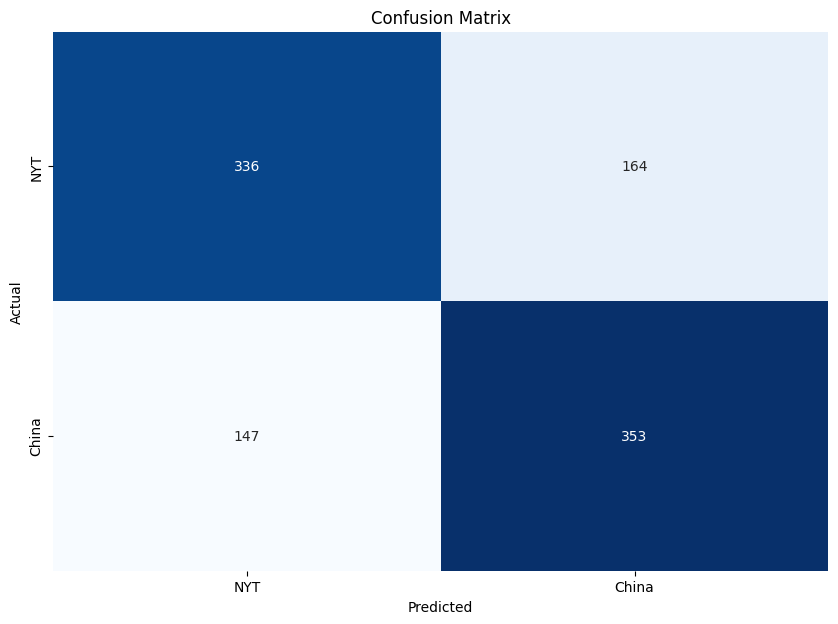

In [23]:
# Plot the confusion matrix nicely
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion, class_names):
    fig, ax = plt.subplots(figsize=(10, 7))  # Set the figure size
    sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Class names for your binary classification
class_names = ['NYT', 'China']

# Plot the confusion matrix
plot_confusion_matrix(confusion, class_names)